In [14]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],
                   timeout=60)

We want to produce a summary graph displaying the latency stability for all destination sites connected to CERN. To do this, we first get a list of site names.

In [44]:
linkName = ['Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2', 'SPRACE',
            'T2-TH-CUNSTDA','EELA-UTFSM', 'TOKYO-LCG2', 'CA-VICTORIA-WESTGRID-T2',
            'ITEP', 'SFU-LCG2','TRIUMF-LCG2', 'UFlorida-HPC', 'UTA_SWT2',
            'SARA-MATRIX', 'WT2', 'INDIACMS-TIFR', 'BU_ATLAS_Tier2', 'LUCILLE',
            'OU_OCHEP_SWT2', 'Nebraska', 'MWT2', 'AGLT2', 'GLOW', 'Vanderbilt',
            'CA-SCINET-T2', 'ru-PNPI', 'BNL-ATLAS', 'RRC-KI',
            'CA-MCGILL-CLUMEQ-T2', 'AM-04-YERPHI', 'CYFRONET-LCG2', 'RRC-KI-T1',
            'CSCS-LCG2', 'RU-Protvino-IHEP', 'RAL-LCG2', 'JINR-T1', 'INFN-BARI',
            'FMPhI-UNIBA', 'JINR-LCG2', 'INFN-ROMA1', 'pic', 'RO-16-UAIC', 
            'FI_HIP_T2', 'RO-07-NIPNE', 'RO-02-NIPNE', 'IFCA-LCG2', 'DESY-ZN',
            'INFN-NAPOLI-ATLAS', 'BEgrid-ULB-VUB', 'DESY-HH',
            'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'INFN-T1', 'IN2P3-LPC',
            'IEPSAS-Kosice', 'IFIC-LCG2', 'UKI-SCOTGRID-GLASGOW',
            'UKI-NORTHGRID-LIV-HEP', 'BUDAPEST', 'UKI-SCOTGRID-ECDF',
            'UKI-SCOTGRID-DURHAM', 'FZK-LCG2', 'UKI-SOUTHGRID-OX-HEP',
            'UAM-LCG2', 'UKI-NORTHGRID-MAN-HEP', 'UKI-SOUTHGRID-CAM-HEP',
            'UKI-SOUTHGRID-SUSX', 'INFN-FRASCATI', 'UKI-SOUTHGRID-BHAM-HEP',
            'IN2P3-CPPM', 'UKI-LT2-QMUL', 'praguelcg2', 'UKI-SOUTHGRID-RALPP',
            'GoeGrid', 'UKI-LT2-UCL-HEP', 'GRIF', 'wuppertalprod', 'IN2P3-LAPP',
            'IN2P3-LPSC', 'INFN-MILANO-ATLASC', 'IN2P3-CC']

Next, get time series data and latency values associated with each link, over a six-month period (binned daily).

In [45]:
import ast

totalHistData = []
totalEpochTime = []
for i in range(len(linkName)):
    query3 = '''{
      "size": 0,
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "query": "srcSite:CERN* AND destSite:%s* AND delay_mean:>0",
              "analyze_wildcard": True,
              "lowercase_expanded_terms": False
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": 1452689502533,
                      "lte": 1468410702533,
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "aggs": {
        "2": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "1d",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
              "min": 1452689502532,
              "max": 1468410702533
            }
          },
          "aggs": {
            "1": {
              "avg": {
                "field": "delay_mean"
              }
            }
          }
        }
      }
    }'''
    query3 = ast.literal_eval(query3%(linkName[i]))
    response = es.search(index="network_weather_2-*", body=query3, request_timeout=600)
    #print(response)
    delayMean = []
    epochTime = []

    for r in response['aggregations']['2']['buckets']:
        #Get field value and timestamp
        delayMean.append(r['1']['value'])
        epochTime.append(r['key'])
        
    #Get times that have values
    delayMean = np.array(delayMean)
    epochTime = np.array(epochTime)

    indices = np.logical_not(np.isnan(delayMean))

    delayMean = delayMean[indices]
    epochTime = epochTime[indices]
    
    totalHistData.append(delayMean)
    totalEpochTime.append(epochTime)

The resultant data may be displayed as box plots, giving an idea of the underlying distribution of the latency for each link.

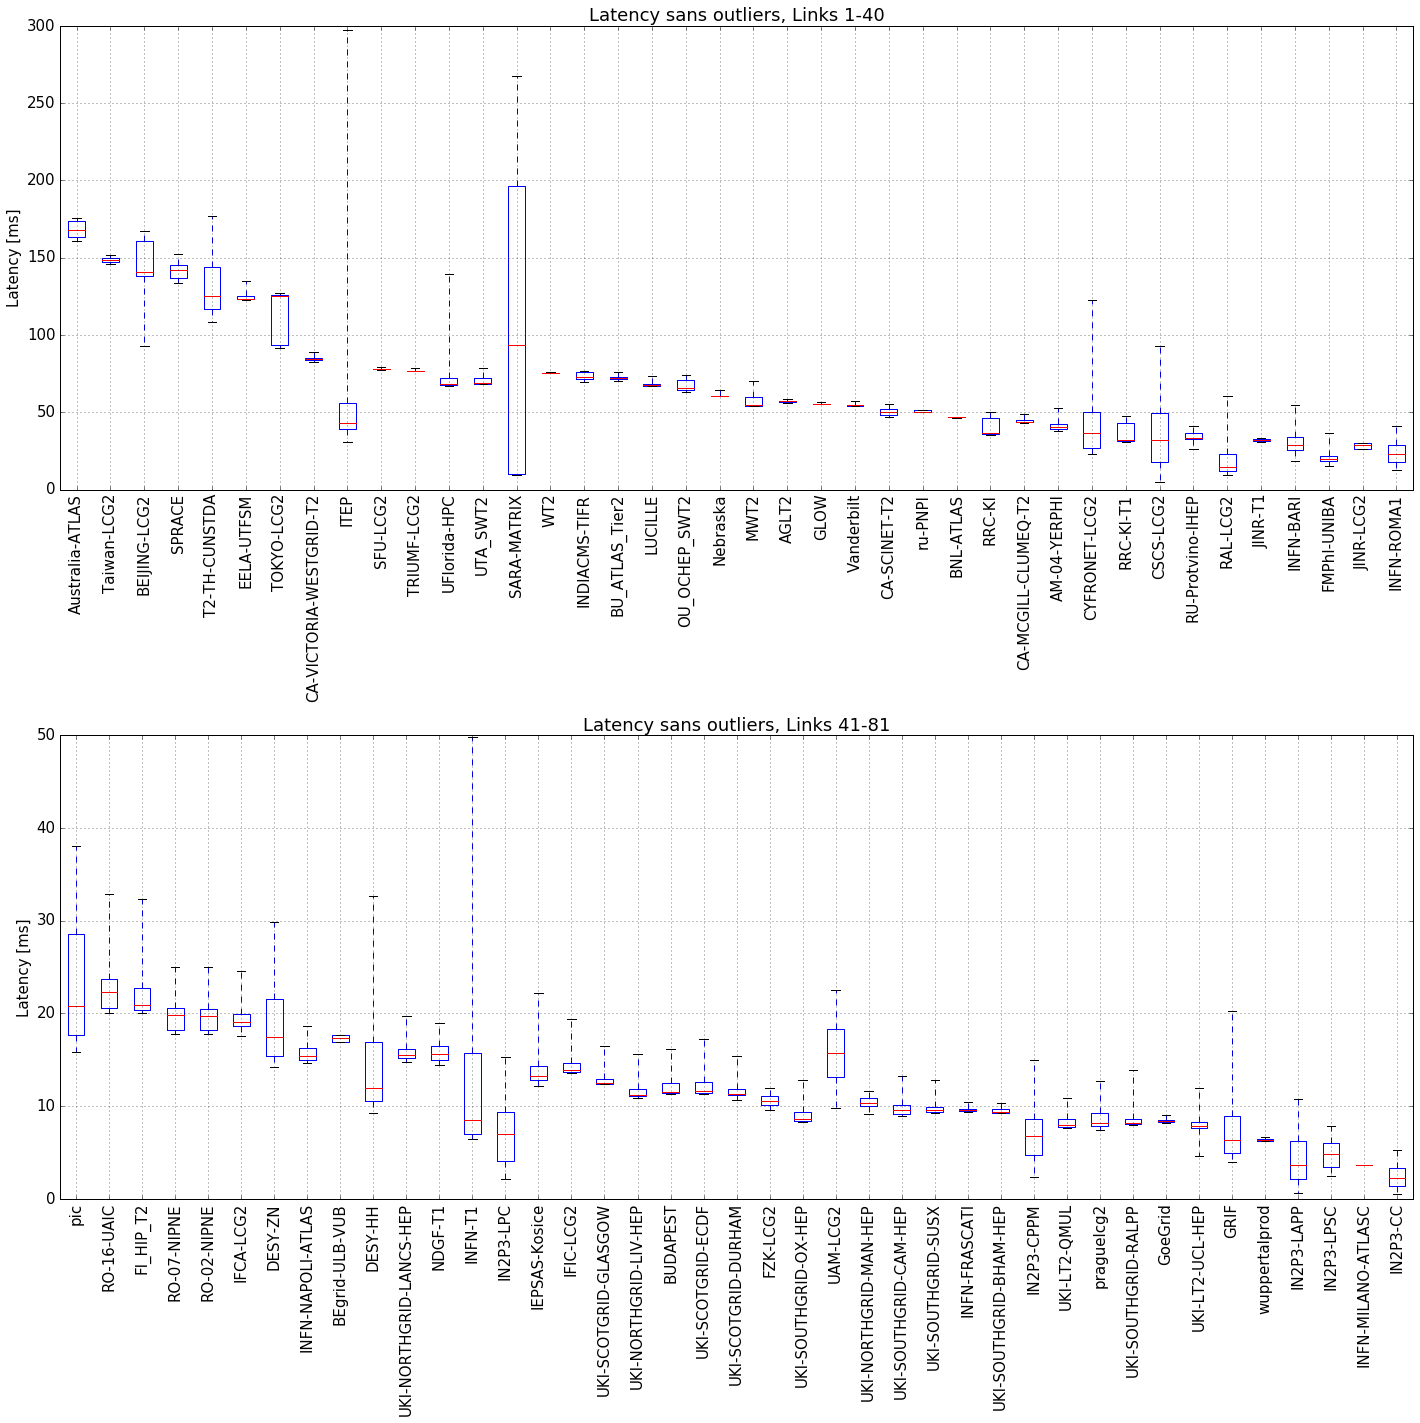

In [46]:
import matplotlib.dates as dt

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.boxplot(totalHistData[0:40], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[0:40])
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Latency [ms]')
plt.title('Latency sans outliers, Links 1-40')

plt.subplot(212)
plt.boxplot(totalHistData[40:], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Latency [ms]')
plt.title('Latency sans outliers, Links 41-81')
plt.grid()

plt.tight_layout()

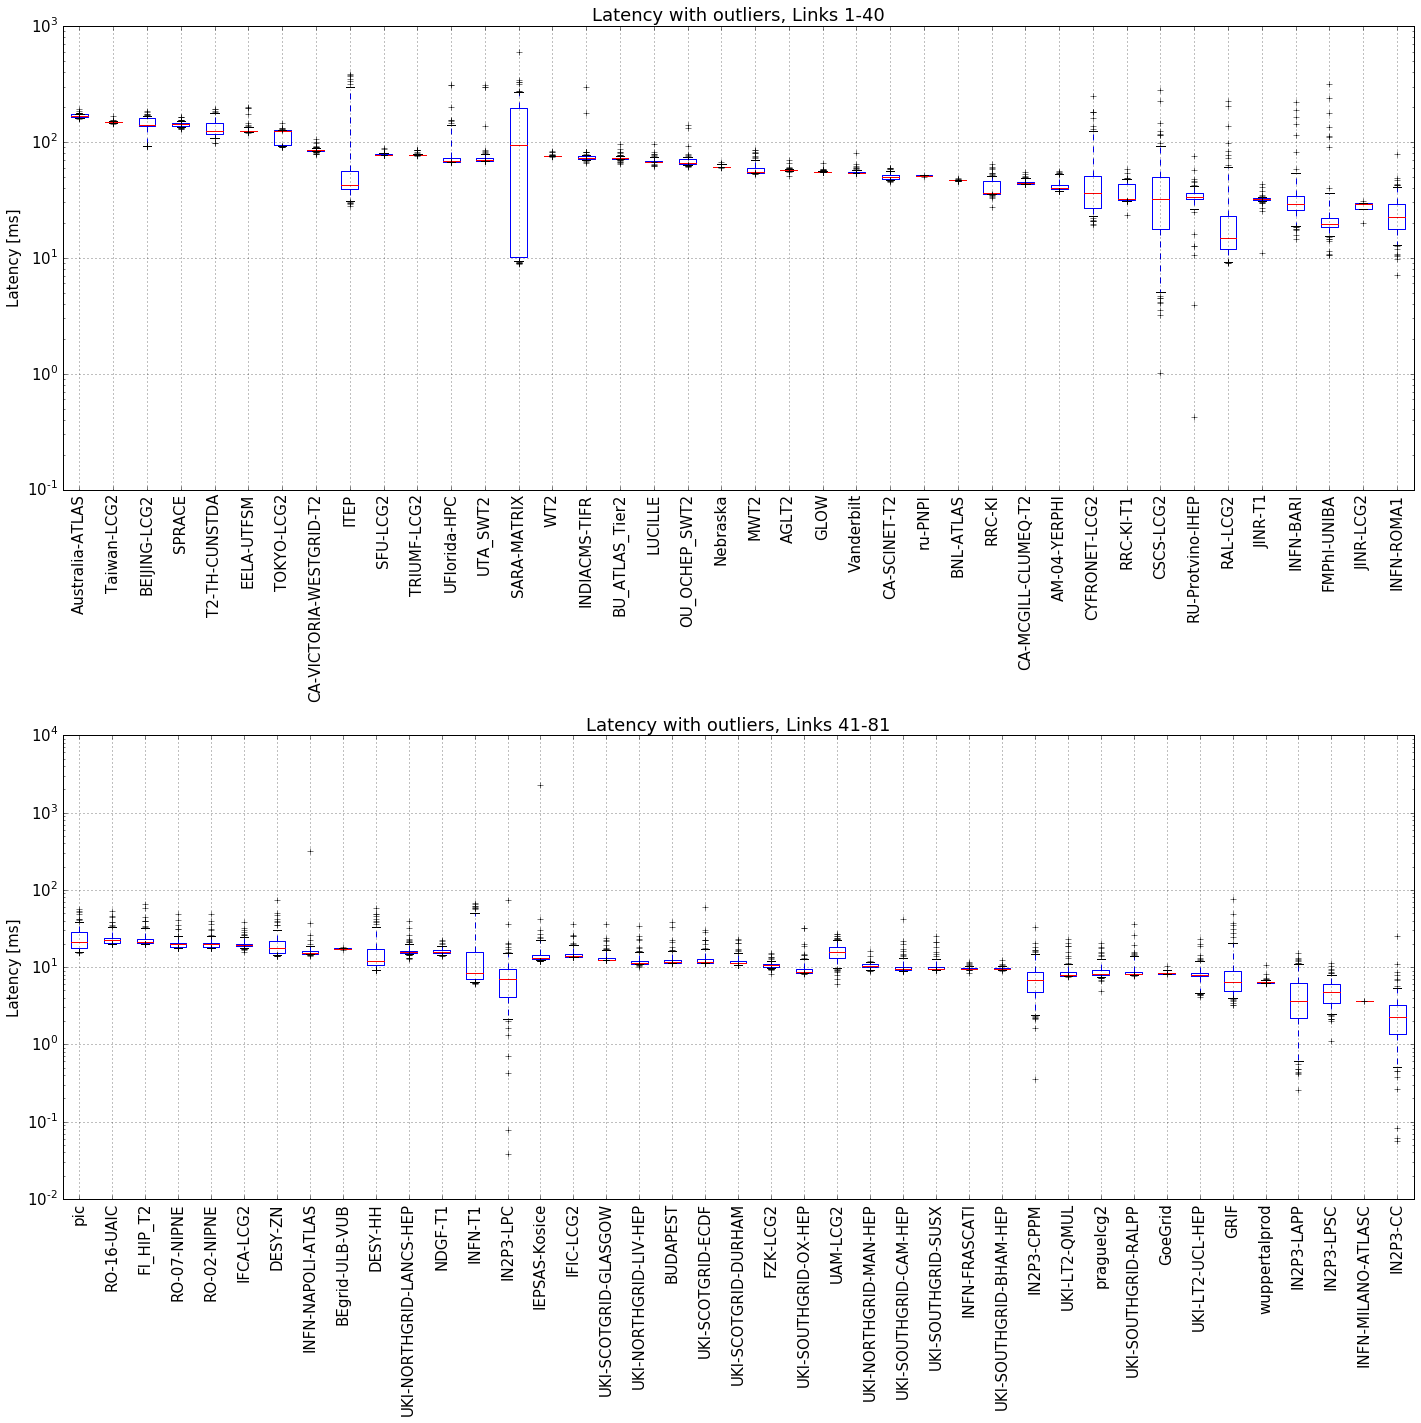

In [26]:
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.boxplot(totalHistData[0:40], whis=[5,95],showfliers=True)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[0:40])
ax.set_yscale('log')
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Latency [ms]')
plt.title('Latency with outliers, Links 1-40')

plt.subplot(212)
plt.boxplot(totalHistData[40:], whis=[5,95],showfliers=True)
ax = plt.gca()
ax.set_yscale('log')
ax.xaxis.set_ticklabels(linkName[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Latency [ms]')
plt.title('Latency with outliers, Links 41-81')
plt.grid()

plt.tight_layout()

In [20]:
histLatency= dict(zip(linkName, totalHistData))
histTime = dict(zip(linkName, totalEpochTime))

Let's zero in on the 'UKI-NORTHGRID-MAN-HEP' link.

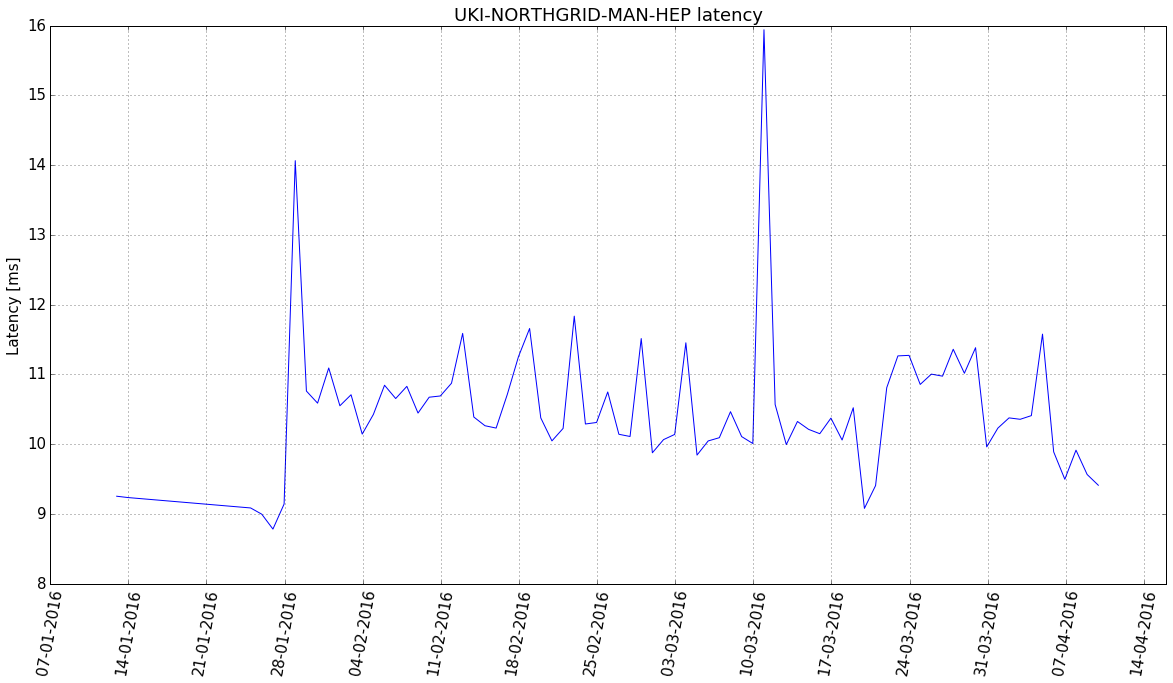

In [30]:
centerName = 'UKI-NORTHGRID-MAN-HEP'

timestamp = dt.epoch2num(histTime[centerName]/1000.)
latency = histLatency[centerName]

plt.figure(figsize=(20,10))
plt.plot(timestamp,latency)

ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()


plt.ylabel('Latency [ms]')

#Manually add extra ticks to histogram plots
ticks = 7
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end,ticks),rotation= 80 )
plt.grid()
plt.title('%s latency'%centerName)
plt.show()